# UC San Diego: Data Science in Practice - Data Checkpoint
### Summer Session I 2023 | Instructor : C. Alex Simpkins Ph.D.

## The Relationship Between Traffic Accidents and the Week of the UCSD Quarter

# Names

- Sumadhu Rubaiyat
- Seiji Yang
- John Carrion
- Ho Lam Woo
- Girish Krishnan
- Sarah Reine Bulatao

<a id='research_question'></a>
# Research Question

Does some ordering of the weeks in a typical UCSD quarter correlate with the weekly number of collisions near UCSD reported to the police?

# Dataset(s)

**Traffic collision reports recorded by the San Diego Police Department**
- Dataset Name: Traffic collisions (2015 through year-to-date)
- Link to the dataset: https://data.sandiego.gov/datasets/police-collisions/
- Number of observations: 64210

This dataset contains information about traffic collisions that were reported to the San Diego Police Department from 2015 to the present. The dataset contains information about the date, time, location, and type of collision. It also contains information about the number of injuries, and the number of fatalities. This is data that is reported to the San Diego Police, so it may not be a complete record of all traffic collisions that occurred in San Diego (as there may be collisions that were not reported to the police).

**Quarter Start/End Dates scraped from UC San Diego's Academic and Administrative Calendars**
- Dataset Name: UCSD Quarter Start and End Dates
- Link to the dataset: `./start_end_dates.json`
- Number of observations: 20

This dataset contains the start and end dates for each academic quarter, scraped from UCSD's academic and administrative calendars. Each observation contains the start and end date for Fall, Winter, and Spring quarters, in that order, and the key corresponds to the academic year. The data covers all quarters from 2003-2024, and was scraped from the URL format: `https://blink.ucsd.edu/instructors/resources/academic/calendars/[YEAR].html`.

**Plan for combining these datasets:** 
We plan to categorize each observation in the Traffic Collision Reports by Week 1-10 in their academic quarter, as well as adding columns for the quarter and year. To do this, we will apply a function to convert the datetime of each observation into its respective week, quarter, and year by checking the date_time against the `start_end_dates` database.

# Data Wrangling

This section demonstrates how to pull all the datasets we need into Python and wrangle the data so that it is in a form that is needed for future analyses and visualization.

### Traffic Collisions Data - San Diego Police
Let's wrangle the data from the San Diego Police Department.

In [60]:
## Import Packages for Data Cleaning / Wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import Packages for Google Maps API function (Keys and Requests)
import requests
from dotenv import load_dotenv

# Import Packages for Calculations
import math
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

COLLISIONS_DATASET_PATH = "collisions_data.csv"

In [61]:
# Fetch collisions dataset, save it locally as well
if not os.path.exists(COLLISIONS_DATASET_PATH):
    print("Fetching collisions dataset...")
    collisions = pd.read_csv('https://seshat.datasd.org/pd/pd_collisions_datasd_v1.csv')
    collisions.to_csv(COLLISIONS_DATASET_PATH)
else:
    print("Collisions dataset already exists locally, reading from file...")
    collisions = pd.read_csv(COLLISIONS_DATASET_PATH)

collisions.head()

Collisions dataset already exists locally, reading from file...


,Unnamed: 0,report_id,date_time,police_beat,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,0,171111,2015-01-14 20:00:00,835,4200,,JUNIPER,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
1,1,192016,2015-03-19 12:00:00,622,5200,,LINDA VISTA,ROAD,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
2,2,190012,2015-03-24 03:05:00,626,1000,W,WASHINGTON,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,2,0,NaN
3,3,191866,2015-03-27 23:56:00,613,2800,,WORDEN,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,1,0,NaN
4,4,185207,2015-07-06 11:45:00,813,2800,,EL CAJON,BOULEVARD,,,,20002(A),VC,HIT AND RUN,0,0,MISDEMEANOR


### Quarter Instruction Start and End Dates - UCSD

There is no existing dataset that contains the start and end dates for each quarter at UCSD. We will need to scrape this data from the UCSD website. We will use the `requests` and `BeautifulSoup` libraries to scrape the data from the UCSD website. We will then use the `json` library to save the data as a JSON file so that we can easily load it into Python in the future.

First, we define a helper function called `find_next_element_after_text`, which parses through the table found on the UCSD academic calendar website, and returns the next element after the element that contains the specified text. This will be useful for finding the start and end dates for each quarter.

In [62]:
import requests
from bs4 import BeautifulSoup
import warnings
import json
import datetime
warnings.filterwarnings("ignore")

# Helper function to find the next element after a given text
def find_next_element_after_text(url, target_text):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    elements_with_target_text = soup.find_all(text=target_text)

    # If no elements with target text are found, try again with lower case on the second word.
    if not elements_with_target_text:
        target_text = target_text.split(' ')[0] + ' ' + target_text.split(' ')[1].lower()
        elements_with_target_text = soup.find_all(text=target_text)

    results = []

    for element_text in elements_with_target_text:
        if element_text.strip() == target_text:
            next_element = element_text.find_next()
            if next_element:
                results.append(next_element.get_text().strip())

    return results

Next, we will use the helper function above to scrape the data from the UCSD website. We will loop through each year from 2003 to 2024, and scrape the start and end dates for each quarter. We will then save the data as a JSON file so that we can easily load it into Python in the future.

In [63]:
# Make a dictionary for each academic quarter, with the quarter name as the key and the start and end dates as the values.
# years from 2003 to 2023
years = [str(i) for i in range(2003, 2024)]
start_end_dates = {}

for year in years:
    url_to_scrape = 'https://blink.ucsd.edu/instructors/resources/academic/calendars/' + year + '.html'
    
    # Indexing:
    # 0: Fall Quarter
    # 1: Winter Quarter
    # 2: Spring Quarter

    # Get the start and end dates for each quarter
    fall_start = find_next_element_after_text(url_to_scrape, 'Instruction Begins')[0] + ' ' + year
    fall_end = find_next_element_after_text(url_to_scrape, 'Instruction Ends')[0] + ' ' + year
    winter_start = find_next_element_after_text(url_to_scrape, 'Instruction Begins')[1] + ' ' + str(int(year) + 1)
    winter_end = find_next_element_after_text(url_to_scrape, 'Instruction Ends')[1] + ' ' + str(int(year) + 1)
    spring_start = find_next_element_after_text(url_to_scrape, 'Instruction Begins')[2] + ' ' + str(int(year) + 1)
    spring_end = find_next_element_after_text(url_to_scrape, 'Instruction Ends')[2] + ' ' + str(int(year) + 1)

    # Remove any asterisks from the dates
    fall_start = fall_start.replace('*', '')
    fall_end = fall_end.replace('*', '')
    winter_start = winter_start.replace('*', '')
    winter_end = winter_end.replace('*', '')
    spring_start = spring_start.replace('*', '')
    spring_end = spring_end.replace('*', '')

    # Add the start and end dates to the dictionary
    start_end_dates[year + '-' + str(int(year) + 1)[-2:]] = [fall_start, fall_end, winter_start, winter_end, spring_start, spring_end]

# Save the dictionary to a file so that we don't have to scrape the website every time we want to use it.
with open('start_end_dates.json', 'w') as fp:
    json.dump(start_end_dates, fp)

Now, let's use these key-value pairs to find the week, quarter, and academic year corresponding to any given date. We will define a helper function called `find_week_and_quarter`, which takes in a date and returns the week, quarter, and academic year corresponding to that date. We will use this function to add columns to the Traffic Collisions dataset that contain the week, quarter, and academic year corresponding to each collision.

In [64]:
def find_week_and_quarter(date):
    # Get the year from the date
    year = date.year
    year = str(year) + '-' + (str(year+1))[-2:]

    # Get the start and end dates for each quarter
    fall_start = datetime.datetime.strptime(start_end_dates[str(year)][0], '%A, %B %d %Y')
    fall_end = datetime.datetime.strptime(start_end_dates[str(year)][1], '%A, %B %d %Y')
    winter_start = datetime.datetime.strptime(start_end_dates[str(year)][2], '%A, %B %d %Y')
    winter_end = datetime.datetime.strptime(start_end_dates[str(year)][3], '%A, %B %d %Y')
    spring_start = datetime.datetime.strptime(start_end_dates[str(year)][4], '%A, %B %d %Y')
    spring_end = datetime.datetime.strptime(start_end_dates[str(year)][5], '%A, %B %d %Y')

    # If the date is in the fall quarter
    if date >= fall_start and date <= fall_end:
        quarter = "Fall"
        days = (date - fall_start).days
        if days < 4:
            week = 0
        else:
            week = (days - 4) // 7 + 1
        return year,quarter, week
    # If the date is in the winter quarter
    elif date >= winter_start and date <= winter_end:
        quarter = "Winter"
        week = (date - winter_start).days // 7 + 1
        return year,quarter, week
    # If the date is in the spring quarter
    elif date >= spring_start and date <= spring_end:
        quarter = "Spring"
        week = (date - spring_start).days // 7 + 1
        return year,quarter, week

    # Otherwise, check the previous year
    else:
        year = date.year - 1
        year = str(year) + '-' + (str(year+1))[-2:]
        fall_start = datetime.datetime.strptime(start_end_dates[str(year)][0], '%A, %B %d %Y')
        fall_end = datetime.datetime.strptime(start_end_dates[str(year)][1], '%A, %B %d %Y')
        winter_start = datetime.datetime.strptime(start_end_dates[str(year)][2], '%A, %B %d %Y')
        winter_end = datetime.datetime.strptime(start_end_dates[str(year)][3], '%A, %B %d %Y')
        spring_start = datetime.datetime.strptime(start_end_dates[str(year)][4], '%A, %B %d %Y')
        spring_end = datetime.datetime.strptime(start_end_dates[str(year)][5], '%A, %B %d %Y')

        # If the date is in the fall quarter
        if date >= fall_start and date <= fall_end:
            quarter = "Fall"
            days = (date - fall_start).days
            if days < 4:
                week = 0
            else:
                week = (days - 4) // 7 + 1
            return year, quarter, week
        # If the date is in the winter quarter
        elif date >= winter_start and date <= winter_end:
            quarter = "Winter"
            week = (date - winter_start).days // 7 + 1
            return year, quarter, week
        # If the date is in the spring quarter
        elif date >= spring_start and date <= spring_end:
            quarter = "Spring"
            week = (date - spring_start).days // 7 + 1
            return year, quarter, week
        else:
            return None, None, None

# Example usage
date = datetime.datetime.strptime('2019-09-26', '%Y-%m-%d')
year, quarter, week = find_week_and_quarter(date)
print("Date:", date)
print("Academic year:", year)
print("Quarter:", quarter)
print("Week:", week)

Date: 2019-09-26 00:00:00
Academic year: 2019-20
Quarter: Fall
Week: 0


Note that the Fall quarter is the only quarter which has a Week 0. All other quarters start at Week 1.

### Merging the Datasets
To merge the datasets, we will take the date and time of each accident in the Traffic Collisions dataset, and use the `find_week_and_quarter` function to find the week, quarter, and academic year corresponding to that date. We will then add columns to the Traffic Collisions dataset that contain the week, quarter, and academic year corresponding to each collision.

In [65]:
# Merging the data
# The date_time column contains the date and time of the collision, so we can use that to find the academic quarter and week.
# We make columns for the academic year, quarter, and week, and then merge the dataframes on those columns.
collisions['date_time'] = pd.to_datetime(collisions['date_time'])
collisions['academic_year'] = collisions['date_time'].apply(lambda x: find_week_and_quarter(x)[0])
collisions['quarter'] = collisions['date_time'].apply(lambda x: find_week_and_quarter(x)[1])
collisions['week'] = collisions['date_time'].apply(lambda x: find_week_and_quarter(x)[2])

# Display the first 5 rows of the dataframe
collisions.head()


,Unnamed: 0,report_id,date_time,police_beat,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl,academic_year,quarter,week
0,0,171111,2015-01-14 20:00:00,835,4200,,JUNIPER,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,2014-15,Winter,2.0
1,1,192016,2015-03-19 12:00:00,622,5200,,LINDA VISTA,ROAD,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR,None,None,NaN
2,2,190012,2015-03-24 03:05:00,626,1000,W,WASHINGTON,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,2,0,NaN,None,None,NaN
3,3,191866,2015-03-27 23:56:00,613,2800,,WORDEN,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,1,0,NaN,None,None,NaN
4,4,185207,2015-07-06 11:45:00,813,2800,,EL CAJON,BOULEVARD,,,,20002(A),VC,HIT AND RUN,0,0,MISDEMEANOR,None,None,NaN


Now, you might notice that:
* Some columns have a `NaN` value for the week, quarter, and academic year. This is because the date of the collision is not during the academic year. For example, the collision may have occurred during the summer, or during the breaks between quarters.
* There are NaN values for other columns as well. This is because the data was not recorded for that particular collision. For example, the data may not have been recorded for the number of injuries or fatalities.
* There are only certain columns of data that we are interested in. We will drop the columns that we do not need.

The next stage is data cleaning, which takes care of these issues and processes the data into a form that is ready for analysis and visualization.

# Data Cleaning

Let's begin by removing excess information, as we only need certain columns to work with our data.

First, we remove the `police_beat`, `violation_selection`, `charge_desc`, `injured`, `killed`, and `violation_type` columns, which aren't necessary for our data. They could also be used to identify the specific accident — though of course, our remaining data (the location) and the type of accident, along with the date and time, are already enough to do that.

When we wrangle the data, we might consider dropping the addresses themselves when working with the data, and making that into a distance category, which may help create some k-anoyminity.

We'll leave `report_id` as a unique identifier for now.

In [66]:
print(collisions.columns) # View the columns of the collisions data table
collisions = collisions.drop(columns=['police_beat','violation_section', 'violation_type', 'charge_desc', 'injured','killed']) # Remove unnecessary columns
collisions.head()

Index(['Unnamed: 0', 'report_id', 'date_time', 'police_beat',
       'address_no_primary', 'address_pd_primary', 'address_road_primary',
       'address_sfx_primary', 'address_pd_intersecting',
       'address_name_intersecting', 'address_sfx_intersecting',
       'violation_section', 'violation_type', 'charge_desc', 'injured',
       'killed', 'hit_run_lvl', 'academic_year', 'quarter', 'week'],
      dtype='object')


,Unnamed: 0,report_id,date_time,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,hit_run_lvl,academic_year,quarter,week
0,0,171111,2015-01-14 20:00:00,4200,,JUNIPER,STREET,,,,MISDEMEANOR,2014-15,Winter,2.0
1,1,192016,2015-03-19 12:00:00,5200,,LINDA VISTA,ROAD,,,,MISDEMEANOR,None,None,NaN
2,2,190012,2015-03-24 03:05:00,1000,W,WASHINGTON,STREET,,,,NaN,None,None,NaN
3,3,191866,2015-03-27 23:56:00,2800,,WORDEN,STREET,,,,NaN,None,None,NaN
4,4,185207,2015-07-06 11:45:00,2800,,EL CAJON,BOULEVARD,,,,MISDEMEANOR,None,None,NaN


Let's take a quick overview of our data.
- We want the shape of our Dataframe.
- We want to check our data types.
- We want to check for any N/A values (i.e. missing data)

In [67]:
print(collisions.shape)

(64191, 14)


There are 64210 rows (observations) and 14 columns (variables).

In [68]:
collisions.dtypes

Unnamed: 0                            int64
report_id                            object
date_time                    datetime64[ns]
address_no_primary                    int64
address_pd_primary                   object
address_road_primary                 object
address_sfx_primary                  object
address_pd_intersecting              object
address_name_intersecting            object
address_sfx_intersecting             object
hit_run_lvl                          object
academic_year                        object
quarter                              object
week                                float64
dtype: object

Now, let's check if any columns have N/A values (missing data).

In [69]:
print(collisions.isna().any())

Unnamed: 0                   False
report_id                    False
date_time                    False
address_no_primary           False
address_pd_primary           False
address_road_primary          True
address_sfx_primary           True
address_pd_intersecting      False
address_name_intersecting     True
address_sfx_intersecting      True
hit_run_lvl                   True
academic_year                 True
quarter                       True
week                          True
dtype: bool


Now, let's remove entries with missing data for academic year, quarter, and week. We will also remove entries with missing data for the UCSD academic year, quarter, and week.

In [70]:
# Remove rows with missing data for academic year, quarter, or week
collisions = collisions.dropna(subset=['academic_year', 'quarter', 'week'])
print(collisions.shape)
collisions.head()

(35352, 14)


,Unnamed: 0,report_id,date_time,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,hit_run_lvl,academic_year,quarter,week
0,0,171111,2015-01-14 20:00:00,4200,,JUNIPER,STREET,,,,MISDEMEANOR,2014-15,Winter,2.0
7,7,1606728,2015-12-01 17:45:00,500,S,36TH,STREET,,,,NaN,2015-16,Fall,10.0
9,9,170160,2016-01-04 07:45:00,5000,,SHAWLINE,STREET,,,,MISDEMEANOR,2015-16,Winter,1.0
10,10,170170,2016-01-04 10:12:00,5500,,UNIVERSITY,AVENUE,,,,NaN,2015-16,Winter,1.0
11,11,170279,2016-01-05 11:45:00,2100,,MEADE,AVENUE,,,,MISDEMEANOR,2015-16,Winter,1.0


We can combine the primary and intersecting addresses into respective single columns, using string concatenation.

In [71]:
collisions = collisions.assign(address_primary = collisions['address_no_primary'].apply(str)+' '+ collisions['address_pd_primary']+' '+collisions['address_road_primary']+' '+collisions['address_sfx_primary'])
collisions = collisions.assign(address_intersecting = collisions['address_pd_intersecting']+' '+collisions['address_name_intersecting']+' '+collisions['address_sfx_intersecting'])
collisions = collisions.drop(columns=['address_no_primary',
       'address_pd_primary', 'address_road_primary', 'address_sfx_primary',
       'address_pd_intersecting', 'address_name_intersecting','address_sfx_intersecting'])
collisions.head()

,Unnamed: 0,report_id,date_time,hit_run_lvl,academic_year,quarter,week,address_primary,address_intersecting
0,0,171111,2015-01-14 20:00:00,MISDEMEANOR,2014-15,Winter,2.0,4200 JUNIPER STREET,
7,7,1606728,2015-12-01 17:45:00,NaN,2015-16,Fall,10.0,500 S 36TH STREET,
9,9,170160,2016-01-04 07:45:00,MISDEMEANOR,2015-16,Winter,1.0,5000 SHAWLINE STREET,
10,10,170170,2016-01-04 10:12:00,NaN,2015-16,Winter,1.0,5500 UNIVERSITY AVENUE,
11,11,170279,2016-01-05 11:45:00,MISDEMEANOR,2015-16,Winter,1.0,2100 MEADE AVENUE,


Even though the first few rows may show a blank value for **address_intersecting**, there are some accidents which have a value for this column.

### Converting addresses into GPS coordinates

We will process the data to convert the addresses in the **address_primary** and **address_intersecting** columns to actual GPS coordinates. This is important because we want to only consider traffic accidents near the UCSD area (more precisely, within 25 kilometers from the GPS location of Geisel library).

**Before running this cell, please do the following:**

* Find your API key for Google Maps
* Create a file called *credentials.env* in the same directory as this notebook.
* Add the following line to your *credentials.env* file:
  * GOOGLE_MAPS_API_KEY=YOUR_API_KEY_HERE

In [72]:
load_dotenv('credentials.env')
GOOGLE_MAPS_API_KEY = os.environ['GOOGLE_MAPS_API_KEY']

def get_gps_coordinates(address,api_key):
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json'

    params = {
        'address': address,
        'key': api_key,
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if data['status'] == 'OK':
        location = data['results'][0]['geometry']['location']
        latitude = location['lat']
        longitude = location['lng']
        return latitude, longitude
    else:
        return '', ''


Now, we apply the `get_gps_coordinates` function to the `address_primary` and `address_intersecting` columns to convert the addresses to GPS coordinates. We will then add columns to the Traffic Collisions dataset that contain the GPS coordinates corresponding to each collision.

For demonstration purposes, we will only convert the first 500 addresses to GPS coordinates. This is because the Google Maps API has a limit of requests per day for free accounts.

In [73]:
# Choose 500 random rows from the collisions dataframe
collisions = collisions.sample(n=500, random_state=1)

# Make new columns for latitude and longitude in the collisions dataframe, and populate them with the GPS coordinates using the function above
# If the primary address is NaN, use the intersecting address
collisions = collisions.assign(latitude = collisions['address_primary'].apply(lambda x: get_gps_coordinates(x,GOOGLE_MAPS_API_KEY)[0] if pd.isna(x) == False else get_gps_coordinates(collisions['address_intersecting'],GOOGLE_MAPS_API_KEY)[0]))
collisions = collisions.assign(longitude = collisions['address_primary'].apply(lambda x: get_gps_coordinates(x,GOOGLE_MAPS_API_KEY)[1] if pd.isna(x) == False else get_gps_coordinates(collisions['address_intersecting'],GOOGLE_MAPS_API_KEY)[1]))

In [74]:
collisions.head()

,Unnamed: 0,report_id,date_time,hit_run_lvl,academic_year,quarter,week,address_primary,address_intersecting,latitude,longitude
5925,5925,171001,2017-02-04 08:48:00,NaN,2016-17,Winter,4.0,11900 RANCHO BERNARDO ROAD,,33.023311,-117.074239
8097,8097,173329,2017-04-23 17:41:00,NaN,2016-17,Spring,3.0,4300 CAM DE LA PLAZA,,32.289543,-110.937791
46699,46699,21203150,2021-05-22 03:14:00,MISDEMEANOR,2020-21,Spring,8.0,0 26TH STREET,PERSHING DRIVE,,
55070,55070,22202659,2022-05-03 21:35:40,MISDEMEANOR,2021-22,Spring,6.0,4600 PALM AVENUE,,,
34473,34473,19206038,2019-12-01 08:12:00,MISDEMEANOR,2019-20,Fall,9.0,10700 GREENFORD DRIVE,,32.913174,-117.132209


Let's save the data back to the CSV file, so we don't have to run the above code again.

In [75]:
# Save the collisions dataframe to a csv file
collisions.to_csv('collisions_data_location.csv')
print("Collisions data saved to collisions_data_location.csv")

Collisions data saved to collisions_data_location.csv


In [76]:
GEISEL_LIBRARY_LATITUDE = 32.881308214955446
GEISEL_LIBRARY_LONGITUDE =  -117.23751225929713
# Source: Google Maps: https://goo.gl/maps/kJBfTsJnx6jzrYcJ7

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude
    in decimal degrees using the Haversine formula.
    """

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad
    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    R_mi = 3958.8  # Radius of Earth in miles
    
    return R_mi * c


In [77]:
# Find observations where latitude and longitude are NOT empty strings
collisions = collisions[(collisions['latitude'] != '') & (collisions['longitude'] != '')]

# Use the Haversine formula defined above, to include only points within 25 miles of Geisel Library
collisions = collisions.assign(distance_to_geisel = collisions.apply(lambda x: haversine(float(x['latitude']),float(x['longitude']),GEISEL_LIBRARY_LATITUDE,GEISEL_LIBRARY_LONGITUDE),axis=1))
collisions = collisions[collisions['distance_to_geisel'] <= 25]
collisions.head()

,Unnamed: 0,report_id,date_time,hit_run_lvl,academic_year,quarter,week,address_primary,address_intersecting,latitude,longitude,distance_to_geisel
5925,5925,171001,2017-02-04 08:48:00,NaN,2016-17,Winter,4.0,11900 RANCHO BERNARDO ROAD,,33.023311,-117.074239,13.633690
34473,34473,19206038,2019-12-01 08:12:00,MISDEMEANOR,2019-20,Fall,9.0,10700 GREENFORD DRIVE,,32.913174,-117.132209,6.493767
36295,36295,20200949,2020-02-07 22:44:00,NaN,2019-20,Winter,5.0,4600 INGRAHAM STREET,,32.800729,-117.24116,5.571593
42000,42000,20206328,2020-10-31 07:30:00,MISDEMEANOR,2020-21,Fall,4.0,0 S 28TH STREET,,32.698381,-117.133811,14.001119
60802,60802,23200697,2023-02-05 19:00:11,MISDEMEANOR,2022-23,Winter,4.0,4000 SPORTS ARENA BOULEVARD,,32.755697,-117.220328,8.736134


In [78]:
# Get the earliest and latest dates in the collisions dataset
print("Earliest date in collisions dataset: {}".format(collisions['date_time'].min()))
print("Latest date in collisions dataset: {}".format(collisions['date_time'].max()))

Earliest date in collisions dataset: 2016-09-23 09:28:00
Latest date in collisions dataset: 2023-06-02 10:00:00


Text(0.5, 1.0, 'Number of Collisions per Week, Grouped by Quarter')

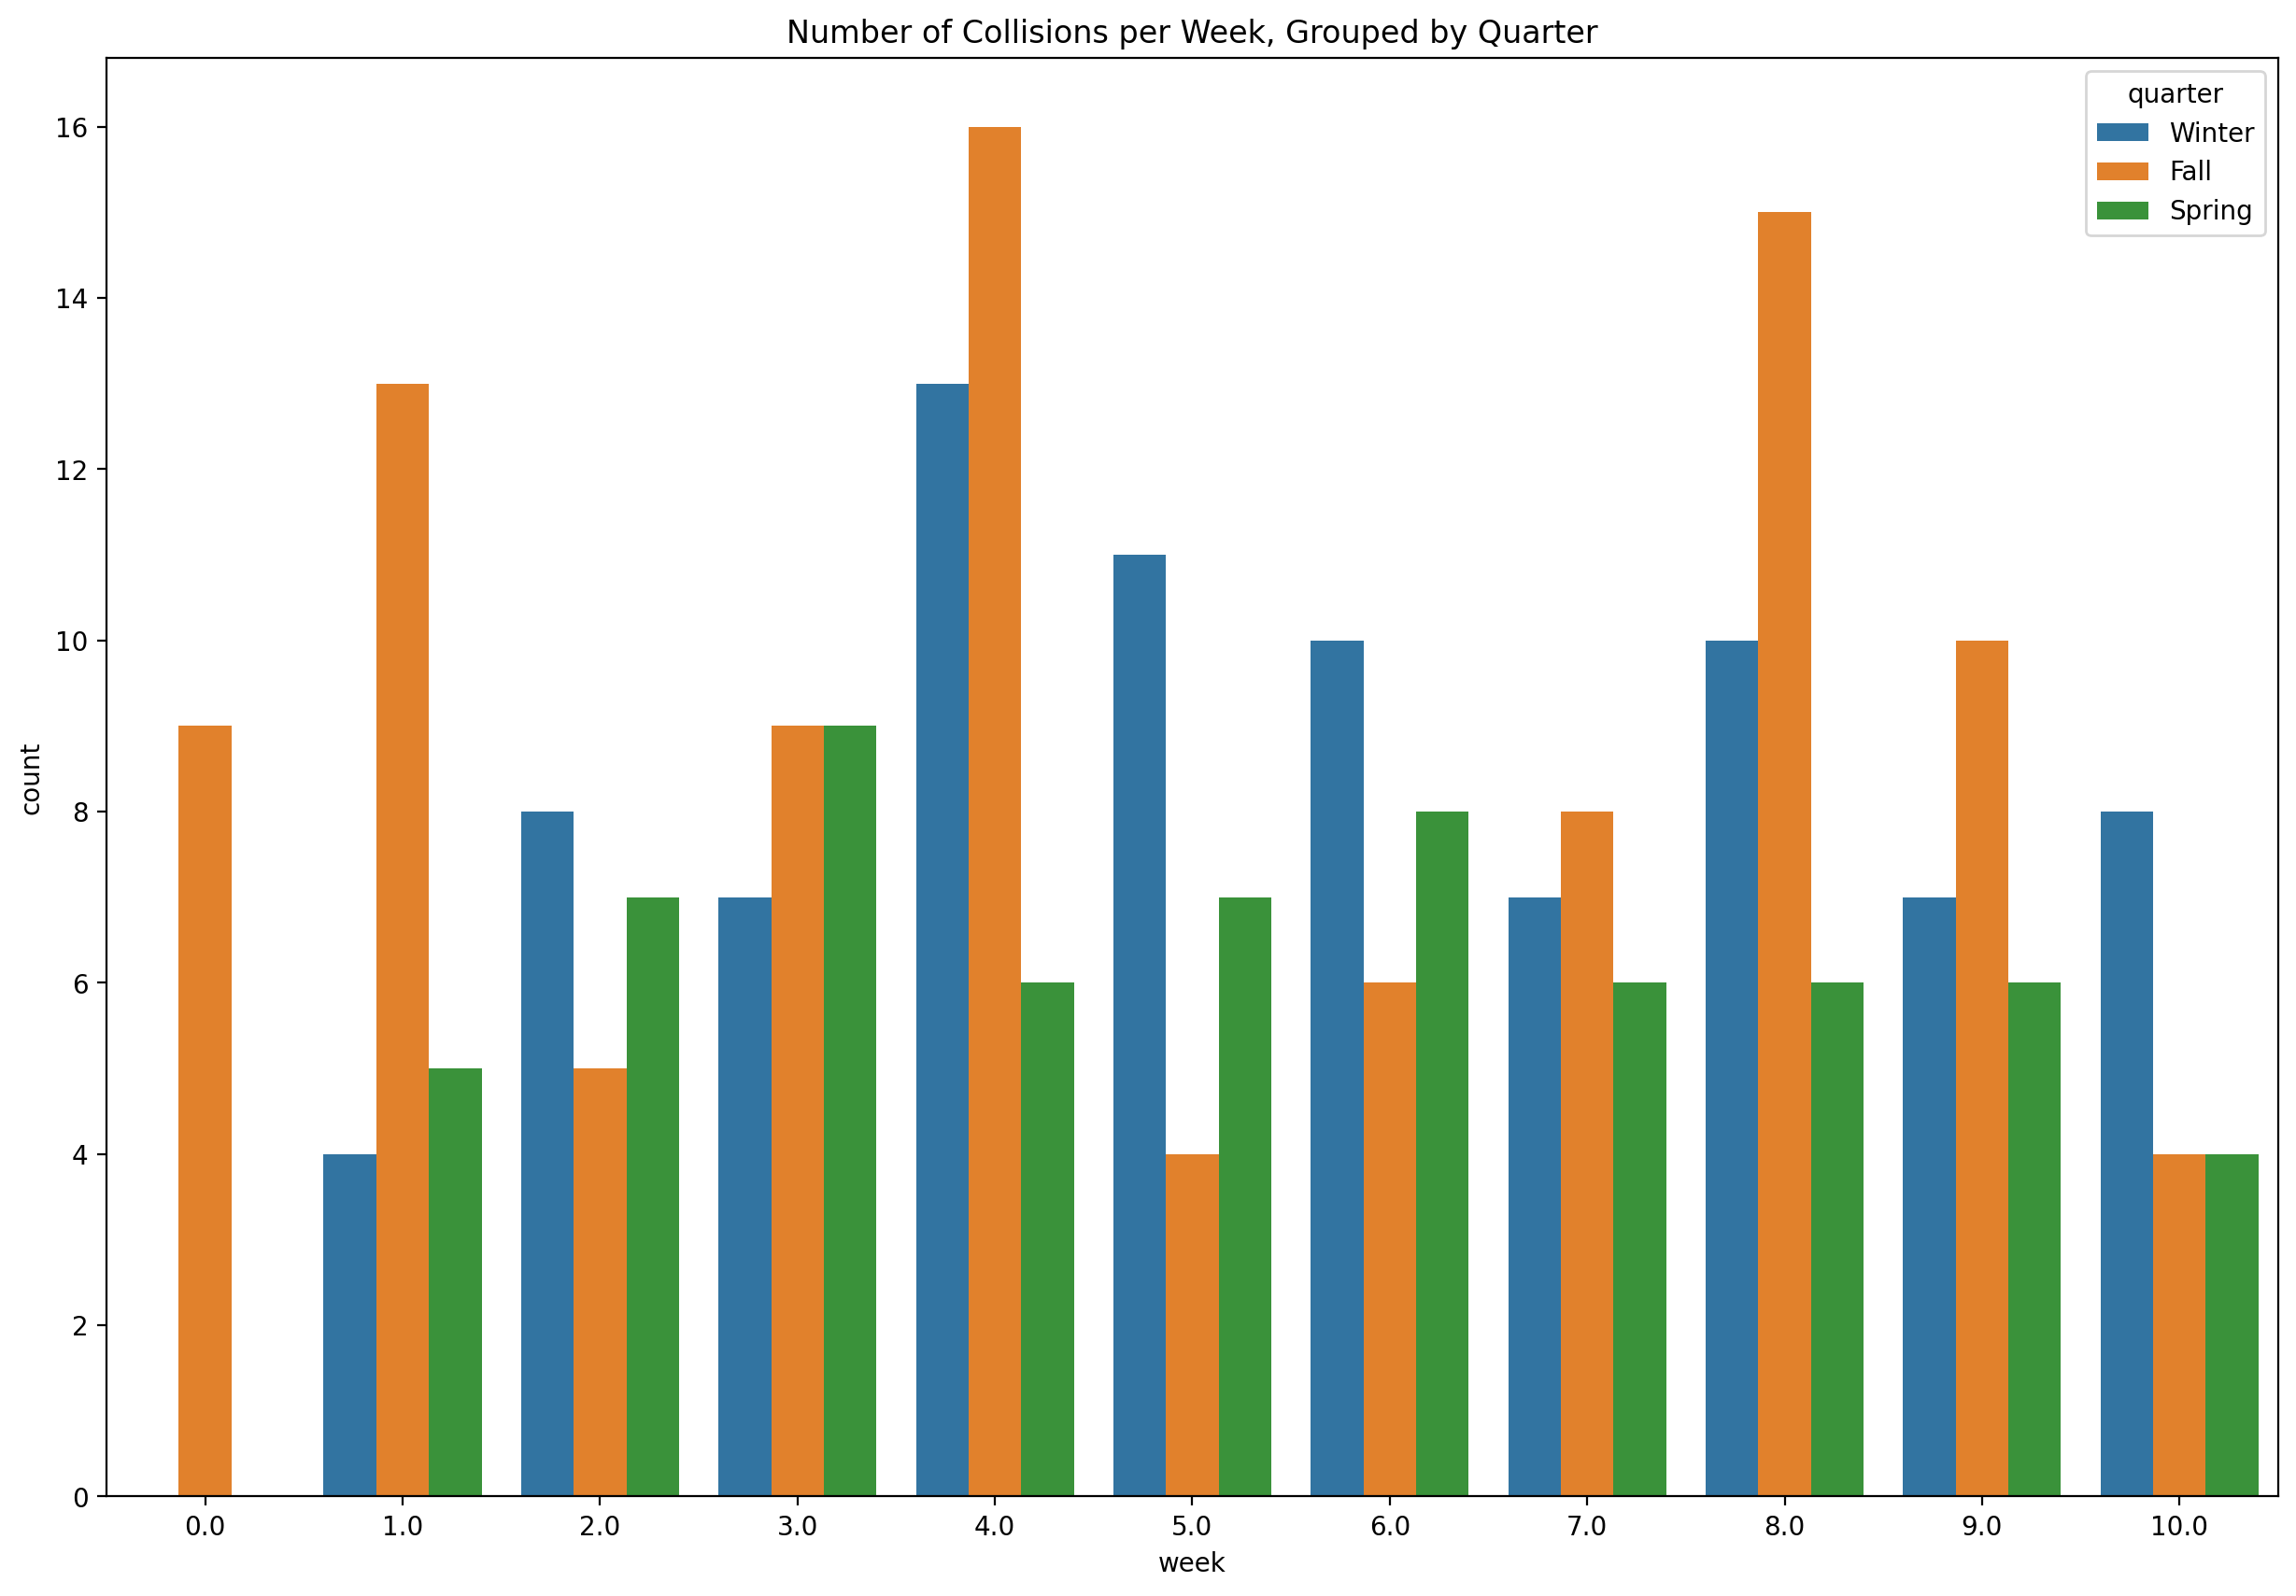

In [79]:
# Plot the number of collisions per week, for each quarter
# Note that the x-axis is the week number, and the y-axis is the number of collisions
# The plot is grouped by quarter
plt.figure(figsize=(15, 10))
sns.countplot(x='week', hue='quarter', data=collisions)
plt.title("Number of Collisions per Week, Grouped by Quarter")